# Histopathologic Cancer Detection using Keras Convolutional Neural Networks


---


The goal is to detect metastatic tissue in histopathological scans of lymph node sections.

The dataset comes from the Kaggle competition:
https://www.kaggle.com/c/histopathologic-cancer-detection/.

The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates). 

- Number of small pathology images in dataset: 220 025
- Dataset size ~ 6 GB
- Single image size: (96, 96, 3)

The project and all calculations were done on the Google Colab platform (GPU) and Google Drive was used for data storage.

## Loading data and displaying sample images

### Imports for data loading and images showing

In [0]:
from google.colab import drive

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import shutil 
import random
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split


### Mounting Google Drive

In [4]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Extracting packed data

In [0]:
shutil.unpack_archive("/content/drive/My Drive/HCD_data.zip", extract_dir="/content/cancer_data/")

### Labels proportion

In [13]:
labels_path='/content/drive/My Drive/Project/'
train_labels = pd.read_csv(f'{labels_path}train_labels.csv')
print(train_labels.shape)

pd.options.display.float_format = '{:.2f}'.format

pd.concat([train_labels['label'].value_counts(), 
                train_labels['label'].value_counts(normalize=True).mul(100)],axis=1, 
                 keys=('counts','percentage'))



(220025, 2)


,counts,percentage
0,130908,59.50
1,89117,40.50


### Getting train, val , test datasets the same as for splitting files 

In [14]:
y = train_labels['label']

df_train, df_test = train_test_split(train_labels, test_size=0.1, random_state=42, stratify=y)

df_train, df_val = train_test_split(train_labels, test_size=0.2, random_state=42, stratify=y)


print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(176020, 2)
(44005, 2)
(22003, 2)


### Printing sample image

(96, 96, 3)


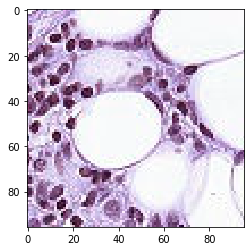

In [0]:
image_path='/content/cancer_data/train/has_tumor/'
has_tumor_df=df_train[df_train['label']==1]
file = image_path + has_tumor_df['id'].iloc[1002] + '.tif'
im = cv2.imread(file)
print(im.shape)
plt.imshow(im)
plt.show()

### Function for showing several images

In [0]:
def draw_category_images(col_name,images_to_show, df, IMAGE_PATH):
    fig, axs = plt.subplots(1,images_to_show, figsize=(10,10)) # adjust size here
        # draw a number of images for each location
    for j in range(0,images_to_show):
        #labels_path=labels_path
        file=IMAGE_PATH + random.choice(os.listdir(image_path))
        im=cv2.imread(file)
        print(im.shape)
        axs[j].imshow(im, resample=True, cmap='gray')
        axs[j].set_title(j, fontsize=16)  
    plt.tight_layout()
    plt.show()

### Tumor images examples

(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)


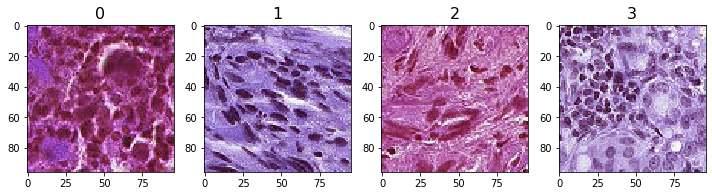

In [0]:
image_path='/content/cancer_data/train/has_tumor/'
random.choice(os.listdir(image_path))
draw_category_images('label', 4, has_tumor_df, image_path)

### No tumor images examples

(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)


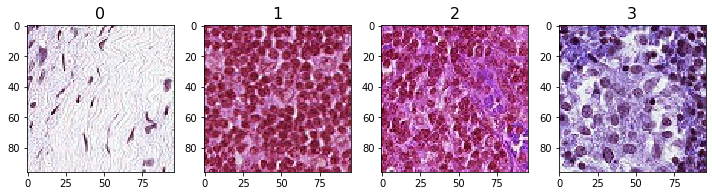

In [0]:
no_tumor_df=df_train[df_train['label']==0]
image_path='/content/cancer_data/train/no_tumor/'
random.choice(os.listdir(image_path))
draw_category_images('label', 4, no_tumor_df, image_path)

## Preparing Keras Data Generators

### Imports

In [0]:
from keras.preprocessing.image import ImageDataGenerator

### Parameters for Image generators and models

In [0]:
img_size=96

data_dir='/content/cancer_data'
path_train = f'{data_dir}/train'
path_val = f'{data_dir}/validation'
path_test = f'{data_dir}/test'

train_len = len(df_train)
val_len=len(df_val)
test_len= len(df_test)

train_batch_size = 65
val_batch_size=65
test_batch_size = 1


train_steps_nr = np.ceil(train_len / train_batch_size)
val_steps_nr = np.ceil(val_len / val_batch_size)
test_steps_nr = np.ceil(test_len / test_batch_size)

### Keras data generators for train, validation and test.

In [16]:
data_gen_args = dict(rescale=1./255,
                     zoom_range=0.2,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     rotation_range=90, 
                     horizontal_flip=True, 
                     vertical_flip=True,
                     brightness_range=[0.5, 1.5])


datagen = ImageDataGenerator(**data_gen_args)

train_generator = datagen.flow_from_directory(
    path_train,
    batch_size=train_batch_size,
    class_mode = 'binary',
    target_size=(img_size,img_size))


val_generator = datagen.flow_from_directory(
    path_val,
    shuffle=True,
    class_mode = 'binary',
    batch_size=val_batch_size,
    target_size=(img_size,img_size))


test_generator = datagen.flow_from_directory(
    path_test,
    class_mode = None,
    shuffle=False,
    target_size=(img_size,img_size),
    batch_size=1)

Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.


### Image Augmentation

The following image processing were used to create the data generators:

- random rotation
- random shift
- random flip (both: horizontal and vertical)
- random rotation
- random lighting
- random zoom

Augumentation were used to achieve better model results and to avoid overfitting.
Below is presented augmentation for one of images.

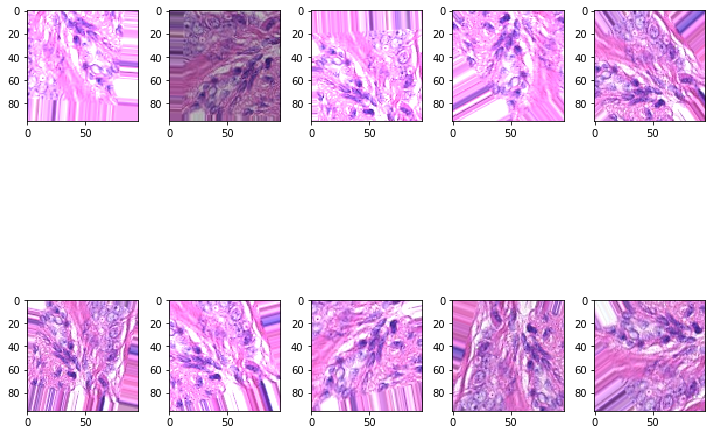

In [0]:
def aug_img_show(img_arr):
    fig, axes = plt.subplots(2, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( img_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
aug_images = [train_generator[0][0][3] for i in range(10)]
aug_img_show(aug_images)

## Bulding models for image classification.

### Imports

In [0]:
import warnings
warnings.filterwarnings('ignore')

from keras.utils.vis_utils import plot_model

from keras.models import load_model

from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score


from keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, \
                          Input, Concatenate, GlobalMaxPooling2D, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam, RMSprop


from sklearn.metrics import confusion_matrix

### Model 1 - User defined model

In [0]:
# Building the model structure
level1_filters = 32
level2_filters = 64
level3_filters = 128
kernel_size = (3,3)
pool_size= (2,2)

dropout_from_conv = 0.3
dropout_from_dense = 0.5

model = Sequential()
model.add(Conv2D(level1_filters, kernel_size, activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Conv2D(level1_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_from_conv))


model.add(Conv2D(level2_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_from_conv))


model.add(Conv2D(level3_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_from_conv))

model.add(Flatten())
model.add(Dense(128, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_from_dense))
model.add(Dense(1, activation = "sigmoid"))

# Compile the model
model.compile(Adam(lr=0.001, ), loss = "binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_5 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 44, 44, 64)       

#### Model 1 Trainning 
Below option was used for trainning:
- Model Checkpoint - save the model after every epoch
- CSVLogger - callback that streams epoch results to a csv file
- ReduceLROnPlateau -  reduce learning rate when a metric has stopped improving.

In [0]:

model1_path='/content/drive/My Drive/Project/HCD_model1.h5'
logs_file_path='/content/drive/My Drive/Project/train_logs_model1.csv'


checkpointer = ModelCheckpoint(model1_path,
                           monitor='val_acc',
                           verbose=True,
                           save_best_only=True,
                           mode='max')
csvlogger = CSVLogger(logs_file_path,
                     append=False,
                     separator=';')

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)


model.fit_generator(train_generator,
                    steps_per_epoch=train_steps_nr, 
                    validation_data=val_generator,
                    validation_steps=val_steps_nr,
                    epochs=12,
                    verbose=True,
                    callbacks=[checkpointer, csvlogger, lr_reducer])

model.load_weights(model1_path)



Epoch 1/12
2708/2708 [==============================] - 919s 339ms/step - loss: 0.4573 - acc: 0.7928 - val_loss: 1.0612 - val_acc: 0.5613

Epoch 00001: val_acc improved from -inf to 0.56135, saving model to /content/drive/My Drive/Project/HCD_model1.h5
Epoch 2/12
2708/2708 [==============================] - 883s 326ms/step - loss: 0.3856 - acc: 0.8319 - val_loss: 0.4175 - val_acc: 0.8197

Epoch 00002: val_acc improved from 0.56135 to 0.81968, saving model to /content/drive/My Drive/Project/HCD_model1.h5
Epoch 3/12
2708/2708 [==============================] - 831s 307ms/step - loss: 0.3564 - acc: 0.8471 - val_loss: 0.3297 - val_acc: 0.8581

Epoch 00003: val_acc improved from 0.81968 to 0.85813, saving model to /content/drive/My Drive/Project/HCD_model1.h5
Epoch 4/12
2708/2708 [==============================] - 779s 288ms/step - loss: 0.3358 - acc: 0.8584 - val_loss: 0.3530 - val_acc: 0.8431

Epoch 00004: val_acc did not improve from 0.85813
Epoch 5/12
2708/2708 [======================

### Model 2 - NASNetMobile
Let's try ready-made model from keras for image classification

NASNet-Mobile is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images

In [0]:
# Bulding the model structure

inputs = Input((96, 96, 3))
NASNet = NASNetMobile(include_top=False,weights=None, input_shape=(96, 96, 3))
base_model = NASNet(inputs)
output1 = GlobalMaxPooling2D()(base_model)
output2 = GlobalAveragePooling2D()(base_model)
output3 = Flatten()(base_model)
output = Concatenate(axis=-1)([output1, output2, output3])
output = Dropout(0.5)(output)
output = Dense(1, activation="sigmoid")(output)
model2 = Model(inputs, output)

# Compile the model 
model2.compile(optimizer=Adam(0.001), loss = "binary_crossentropy",
              metrics = ["accuracy"])
model2.summary()















Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
NASNet (Model)                  (None, 3, 3, 1056)   4269716     input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 1056)         0           NASNet[1][0]                     
_________________________________________________________________

#### Model 2 Trainning

In [0]:
model2_path='/content/drive/My Drive/Project/HCD_model2.h5'
logs_file_path2='/content/drive/My Drive/Project/train_logs_model2.csv'

checkpointer = ModelCheckpoint(model2_path,
                           monitor='val_acc',
                           verbose=True,
                           save_best_only=True,
                           mode='max')
csvlogger = CSVLogger(logs_file_path2,
                     append=False,
                     separator=';')

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)


model2.fit_generator(train_generator,
                    steps_per_epoch=train_steps_nr, 
                    validation_data=val_generator,
                    validation_steps=val_steps_nr,
                    epochs=12,
                    verbose=True,
                    callbacks=[checkpointer, csvlogger, lr_reducer])

model2.load_weights(model2_path)

Epoch 1/12
2708/2708 [==============================] - 1625s 600ms/step - loss: 0.5805 - acc: 0.7581 - val_loss: 9.5899 - val_acc: 0.4050

Epoch 00001: val_acc improved from -inf to 0.40502, saving model to /content/drive/My Drive/Project/HCD_model2.h5
Epoch 2/12
2708/2708 [==============================] - 1608s 594ms/step - loss: 0.5529 - acc: 0.7604 - val_loss: 6.4570 - val_acc: 0.5950

Epoch 00002: val_acc improved from 0.40502 to 0.59498, saving model to /content/drive/My Drive/Project/HCD_model2.h5
Epoch 3/12
2708/2708 [==============================] - 1608s 594ms/step - loss: 0.5318 - acc: 0.7727 - val_loss: 6.2317 - val_acc: 0.5983

Epoch 00003: val_acc improved from 0.59498 to 0.59830, saving model to /content/drive/My Drive/Project/HCD_model2.h5
Epoch 4/12
2708/2708 [==============================] - 1608s 594ms/step - loss: 0.5180 - acc: 0.7645 - val_loss: 4.9923 - val_acc: 0.5928

Epoch 00004: val_acc did not improve from 0.59830
Epoch 5/12
2708/2708 [====================

### Model 3 VGG16

VGG16 is a convolution neural net (CNN ) with pre-trained weights. It was used to win Imagenet competition in 2014.  
The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large and it has about 138 million parameters.

In [0]:
# Building the model structure
VGG16_net = VGG16(weights='imagenet',include_top = False, input_shape=(img_size, img_size, 3))

model3 = Sequential()
model3.add(VGG16_net)
    
model3.add(GlobalAveragePooling2D())
model3.add(Dense(256, use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(1))
model3.add(Activation('sigmoid'))

# Compile the model
model3.compile(optimizer=Adam(0.001), loss = "binary_crossentropy",
              metrics = ["accuracy"])

model3.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131072    
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_______________________________________________________

#### Model 3 Trainning

In [0]:
model3_path='/content/drive/My Drive/Project/HCD_model3.h5'
logs_file_path3='/content/drive/My Drive/Project/train_logs_model3.csv'

checkpointer = ModelCheckpoint(model3_path,
                           monitor='val_acc',
                           verbose=True,
                           save_best_only=True,
                           mode='max')
csvlogger = CSVLogger(logs_file_path3,
                     append=False,
                     separator=';')

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)


model3.fit_generator(train_generator,
                    steps_per_epoch=train_steps_nr, 
                    validation_data=val_generator,
                    validation_steps=val_steps_nr,
                    epochs=12,
                    verbose=True,
                    callbacks=[checkpointer, csvlogger, lr_reducer])

model3.load_weights(model3_path)

Epoch 1/12
2708/2708 [==============================] - 742s 274ms/step - loss: 0.5026 - acc: 0.7625 - val_loss: 0.8680 - val_acc: 0.5609

Epoch 00001: val_acc improved from -inf to 0.56089, saving model to /content/drive/My Drive/Project/HCD_model3.h5
Epoch 2/12
2708/2708 [==============================] - 736s 272ms/step - loss: 0.4361 - acc: 0.8054 - val_loss: 0.5173 - val_acc: 0.7609

Epoch 00002: val_acc improved from 0.56089 to 0.76087, saving model to /content/drive/My Drive/Project/HCD_model3.h5
Epoch 3/12
2708/2708 [==============================] - 765s 282ms/step - loss: 0.3841 - acc: 0.8338 - val_loss: 0.3571 - val_acc: 0.8474

Epoch 00003: val_acc improved from 0.76087 to 0.84740, saving model to /content/drive/My Drive/Project/HCD_model3.h5
Epoch 4/12
2708/2708 [==============================] - 814s 301ms/step - loss: 0.2951 - acc: 0.8798 - val_loss: 0.2754 - val_acc: 0.8871

Epoch 00004: val_acc improved from 0.84740 to 0.88706, saving model to /content/drive/My Drive/P

### Models Results on test set

In [0]:
# Loading models from files

model1 = load_model('/content/drive/My Drive/Project/HCD_model1.h5', compile=False)
model2 = load_model('/content/drive/My Drive/Project/HCD_model2.h5', compile=False)
model3 = load_model('/content/drive/My Drive/Project/HCD_model3.h5', compile=False)

In [61]:
# Making prediction from all models
predictions={}
predictions['model1'] = model1.predict_generator(test_generator, steps=len(df_test), verbose=1)
predictions['model2'] = model2.predict_generator(test_generator, steps=len(df_test), verbose=1)
predictions['model3'] = model3.predict_generator(test_generator, steps=len(df_test), verbose=1)

22003/22003 [==============================] - 612s 28ms/step


In [35]:
# Accuracy score, AUC score and F1 score on test set

models_list=['Defined Model', 'NASNet-Mobile', 'VGG16' ]
scores={}


for i in range(3):

  y_pred = predictions[f'model{i+1}'] > 0.5
  fpr, tpr, threshold = roc_curve(test_generator.classes, y_pred)
  f1=f1_score(test_generator.classes, y_pred)
  auc_score = auc(fpr, tpr)
  acc = accuracy_score(test_generator.classes, y_pred)
  
  scores[models_list[i]]=[acc, auc_score, f1]
  


pd.DataFrame(scores, index=['Accuracy', 'AUC', 'F1 Score'])


,Defined Model,NASNet-Mobile,VGG16
Accuracy,0.90,0.77,0.94
AUC,0.89,0.79,0.93
F1 Score,0.91,0.79,0.95


#### Confusion matrixes

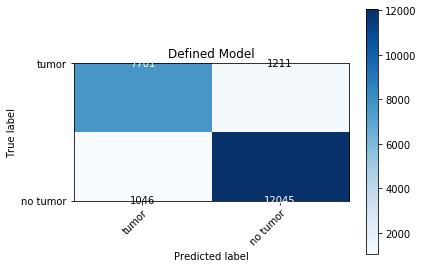

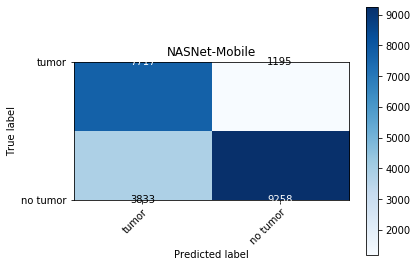

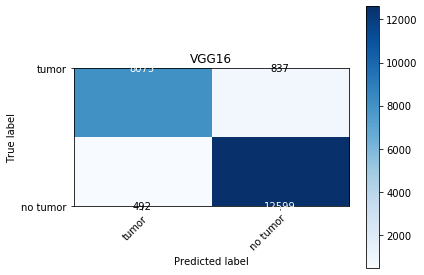

In [81]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):     

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=1)

for n in range(3):

  y_pred = predictions[f'model{n+1}'] > 0.5
  
  plot_confusion_matrix(test_generator.classes, y_pred, classes=['tumor', 'no tumor'],
                        title=models_list[n])


plt.tight_layout()
plt.show()

### Summary
The best result was achieved by the VGG16 network which has 93% accuracy on the test set. The other 2 networks turned out to be much weaker. I think this result could be further improved with increasing epochs and extension of augumentation.